# MLP
Mean RCI over 14 cell lines.

This notebook uses
lncRNA, canonical, no middle-exclusion train, no middle-exclusion test, -1 threshold, learning module, cross-validation.

In [1]:
SEED = 43
import tensorflow as tf
tf.random.set_seed(SEED) 
tf.keras.backend.set_floatx('float32')
import numpy as np
np.random.seed(SEED) 
from datetime import datetime
print(datetime.now())

2023-05-01 13:04:00.181823


In [2]:
import sys
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
    MODEL_DIR=PATH+'My Drive/data/Localization/Models/'  # must end in "/"
    sys.path.append('/content/drive/My Drive/Colab Notebooks')
except:
    IN_COLAB = False
    DATA_DIR="/"
    MODEL_DIR="/"
print(DATA_DIR)
SAVE_MODEL_FILENAME = 'MLP_NoNo'
SAVE_DESCRIM_FILENAME = 'GMM_NoNo'
LOAD_MODEL_FILENAME = None # 'MLP.0.0.model'
LOAD_DESCRIM_FILENAME = None # 'GMM.0.0.pickle'

GPU device not found
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from learning import DataLoader, CrossValidator, Separator, ModelBuilder

K=5
ALPHABET=4**K + 1
EPOCHS=300 
EMBED_DIMEN = 4 # arbitrary hyperparameter
RCI_THRESHOLD_MECHANISM = 'ZERO'   # 'RCI_GMM' 'ZERO' 'THE_MEAN'
RCI_THRESHOLD_VALUE = -1  # use -1 for lncRNA, use 0 for mRNA
BREAK = False   # optionally break after first fold
FILTER_TRAIN        = False
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = False
FILTER_TEST         = False
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = False
MIDDLE_LOW          = -2   # -2 for lncRNA, -1 for mRNA
MIDDLE_HIGH         = 0    #  0 for lncRNA, +1 for mRNA

REPEATS = 2
FOLDS = 5

Python 3.10.11
sklearn 1.2.2


In [4]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.all_cell_lines.csv'
RCI_FILE_TEST  = None # 'test.lncRNA_RCI.all_cell_lines.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # 'test.canon_lncRNA_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()
EXCLUSIONS = [1]  # H1.hESC   
print('Exclusions',EXCLUSIONS)

Exclusions [1]


In [6]:
from tensorflow import keras
from keras import models
import pickle

def save_model(model, discriminator, filename1, filename2):
    filepath = MODEL_DIR + filename1
    model.save(filepath)
    print('Saved model 1 to',filepath)
    filepath = MODEL_DIR + filename2
    pickle.dump(discriminator, open(filepath, 'wb'))
    print('Saved model 2 to',filepath)

def load_model(filename1, filename2):
    filepath = MODEL_DIR + filename1
    model = keras.models.load_model(filepath)
    print('Loaded model 1 from',filepath)
    filepath = MODEL_DIR + filename2
    discriminator = pickle.load(open(filepath, 'rb'))        
    print('Loaded model 2 from',filepath)
    return model, discriminator
        

2023-05-01 13:04:03.066329
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 4372
Num RCI: 4372
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4372 sequences.

Training # 1 1
2023-05-01 13:04:14.465059
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.1.validation_genes.txt
Discriminator ZERO -1
Train 1:0 1810:1687 51.76%
Computed class weights: {0: 1.0364552459988146, 1: 0.9660220994475138}
Valid 1:0 433:442 49.49%
FIT


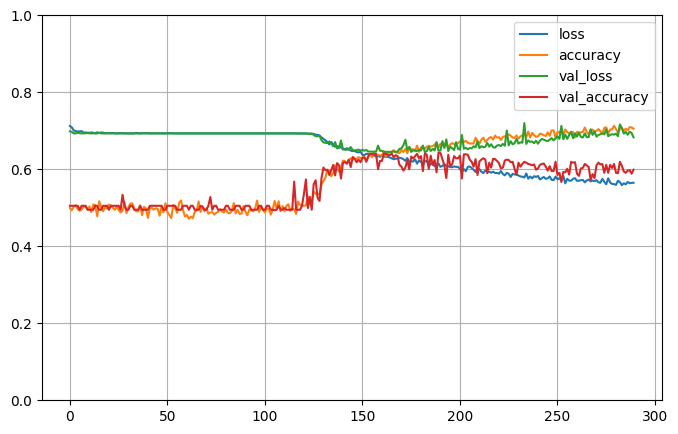

Saved model 1 to /content/drive/My Drive/data/Localization/Models/MLP_NoNo.1.1.model
Saved model 2 to /content/drive/My Drive/data/Localization/Models/GMM_NoNo.1.1.pickle

Testing # 1 1
2023-05-01 13:07:35.905144
PREDICT
Test 1:0 433:442 49.49%
Predict 1:0 471:404 53.83%
Test sizes (875, 1025) (875,)
Distrib of scores: 0.5033999 mean 0.18625714 std
Range of scores: 0.030326454 to 0.8866003
Score threshold 0.5
Confusion matrix
 [[267 175]
 [137 296]]
Normalized matrix
 [[0.30514286 0.2       ]
 [0.15657143 0.33828571]]
Extreme scores correct, pos:neg 152 130
Extreme scores incorrect pos:neg 69 58


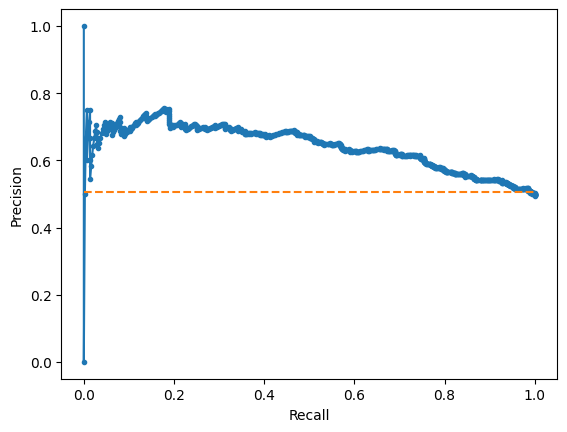

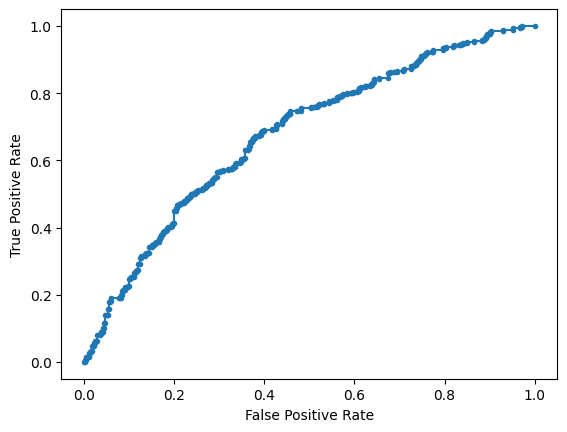

Accuracy: 64.34% Precision: 62.85% Recall: 68.36%
F1: 65.49% MCC: 0.2885
AUPRC: 64.15% AUROC: 67.69%
 accuracy [64.34285714285714]
 precision [62.84501061571125]
 recall [68.36027713625866]
 F1 [65.48672566371681]
 MCC [0.28850697982321755]
 AUPRC [64.15481853917643]
 AUROC [67.68572413865174]

Training # 1 2
2023-05-01 13:07:36.846461
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.2.validation_genes.txt
Discriminator ZERO -1
Train 1:0 1789:1708 51.16%
Computed class weights: {0: 1.023711943793911, 1: 0.9773616545556176}
Valid 1:0 454:421 51.89%
FIT


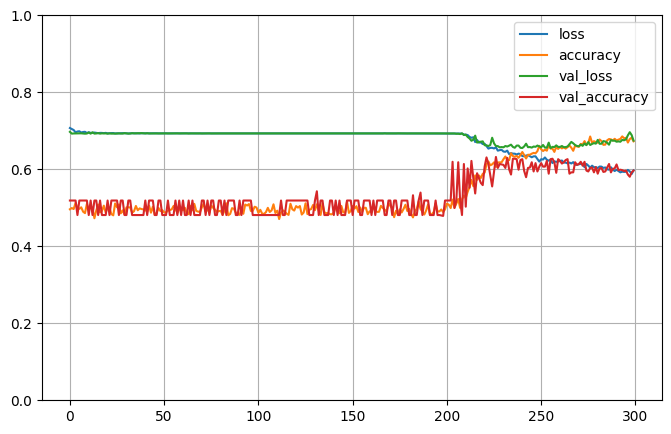

Saved model 1 to /content/drive/My Drive/data/Localization/Models/MLP_NoNo.1.2.model
Saved model 2 to /content/drive/My Drive/data/Localization/Models/GMM_NoNo.1.2.pickle

Testing # 1 2
2023-05-01 13:11:01.491543
PREDICT
Test 1:0 454:421 51.89%
Predict 1:0 475:400 54.29%
Test sizes (875, 1025) (875,)
Distrib of scores: 0.50338364 mean 0.19623242 std
Range of scores: 0.0052724583 to 0.8947936
Score threshold 0.5
Confusion matrix
 [[234 187]
 [166 288]]
Normalized matrix
 [[0.26742857 0.21371429]
 [0.18971429 0.32914286]]
Extreme scores correct, pos:neg 145 141
Extreme scores incorrect pos:neg 86 63


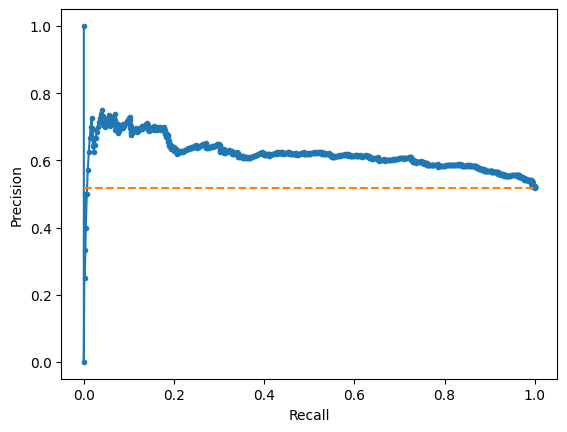

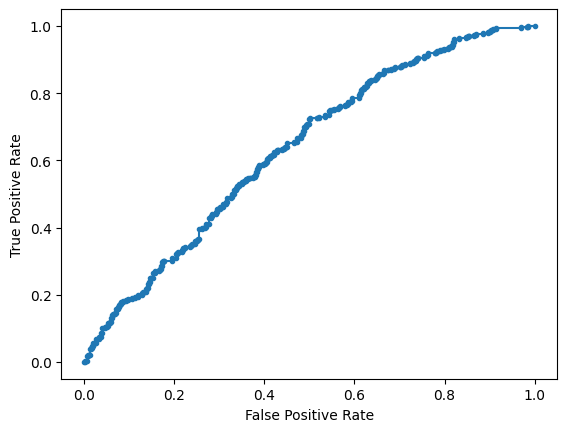

Accuracy: 59.66% Precision: 60.63% Recall: 63.44%
F1: 62.00% MCC: 0.1907
AUPRC: 61.88% AUROC: 63.50%
 accuracy [59.65714285714285]
 precision [60.631578947368425]
 recall [63.436123348017624]
 F1 [62.00215285252961]
 MCC [0.1907474058836505]
 AUPRC [61.884066496857415]
 AUROC [63.49995291261627]

Training # 1 3
2023-05-01 13:11:02.145552
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.3.validation_genes.txt
Discriminator ZERO -1
Train 1:0 1810:1688 51.74%
Computed class weights: {0: 1.036137440758294, 1: 0.9662983425414364}
Valid 1:0 433:441 49.54%
FIT


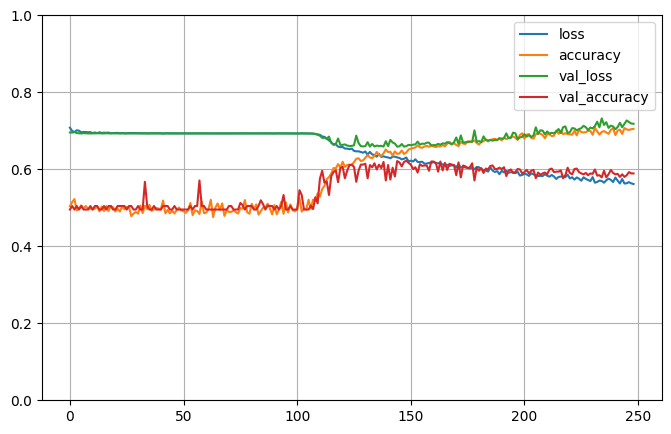

Saved model 1 to /content/drive/My Drive/data/Localization/Models/MLP_NoNo.1.3.model
Saved model 2 to /content/drive/My Drive/data/Localization/Models/GMM_NoNo.1.3.pickle

Testing # 1 3
2023-05-01 13:13:46.571324
PREDICT
Test 1:0 433:441 49.54%
Predict 1:0 461:413 52.75%
Test sizes (874, 1025) (874,)
Distrib of scores: 0.504468 mean 0.15771975 std
Range of scores: 0.033811845 to 0.8585109
Score threshold 0.5
Confusion matrix
 [[262 179]
 [151 282]]
Normalized matrix
 [[0.29977117 0.20480549]
 [0.17276888 0.32265446]]
Extreme scores correct, pos:neg 108 101
Extreme scores incorrect pos:neg 56 40


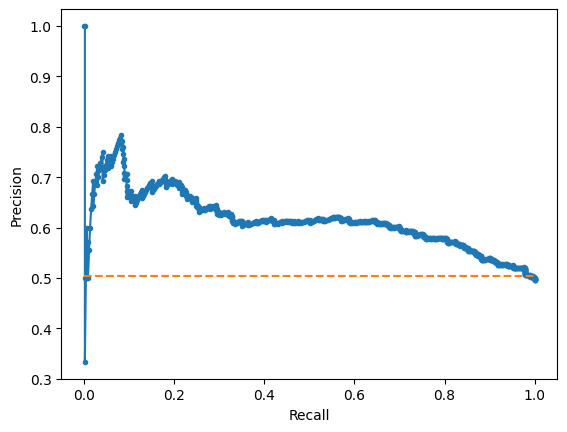

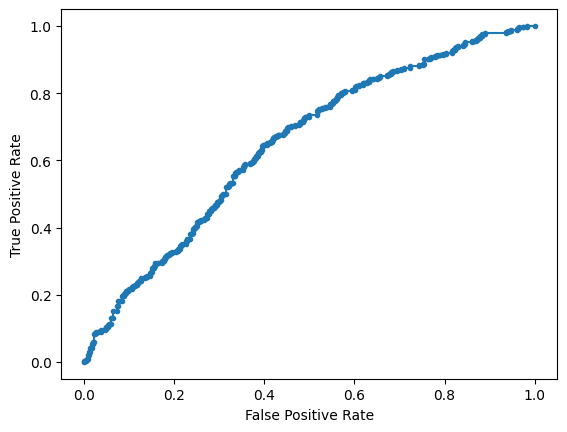

Accuracy: 62.24% Precision: 61.17% Recall: 65.13%
F1: 63.09% MCC: 0.2457
AUPRC: 61.47% AUROC: 64.86%
 accuracy [62.24256292906178]
 precision [61.17136659436009]
 recall [65.1270207852194]
 F1 [63.08724832214765]
 MCC [0.24573510942877533]
 AUPRC [61.46522316576251]
 AUROC [64.85627353327783]

Training # 1 4
2023-05-01 13:13:47.196993
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.4.validation_genes.txt
Discriminator ZERO -1
Train 1:0 1778:1720 50.83%
Computed class weights: {0: 1.0168604651162791, 1: 0.9836895388076491}
Valid 1:0 465:409 53.20%
FIT


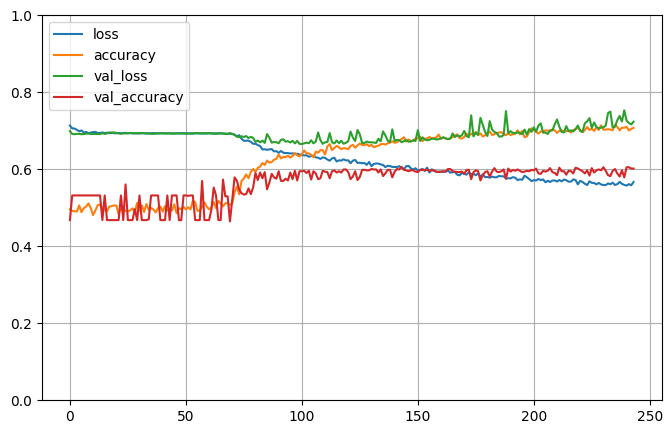

Saved model 1 to /content/drive/My Drive/data/Localization/Models/MLP_NoNo.1.4.model
Saved model 2 to /content/drive/My Drive/data/Localization/Models/GMM_NoNo.1.4.pickle

Testing # 1 4
2023-05-01 13:16:29.894601
PREDICT
Test 1:0 465:409 53.20%
Predict 1:0 559:315 63.96%
Test sizes (874, 1025) (874,)
Distrib of scores: 0.5555716 mean 0.17489958 std
Range of scores: 0.016892646 to 0.87304074
Score threshold 0.5
Confusion matrix
 [[190 219]
 [125 340]]
Normalized matrix
 [[0.2173913  0.25057208]
 [0.14302059 0.38901602]]
Extreme scores correct, pos:neg 193 80
Extreme scores incorrect pos:neg 103 34


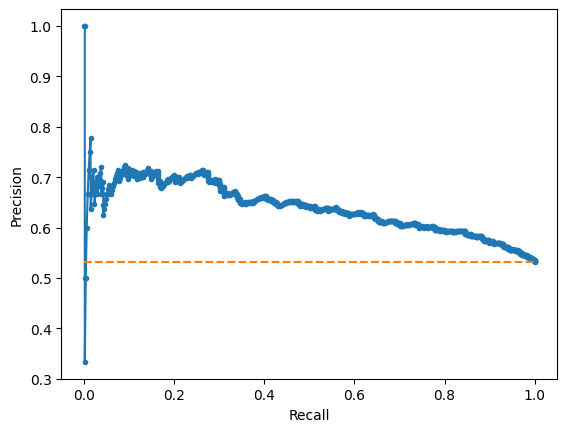

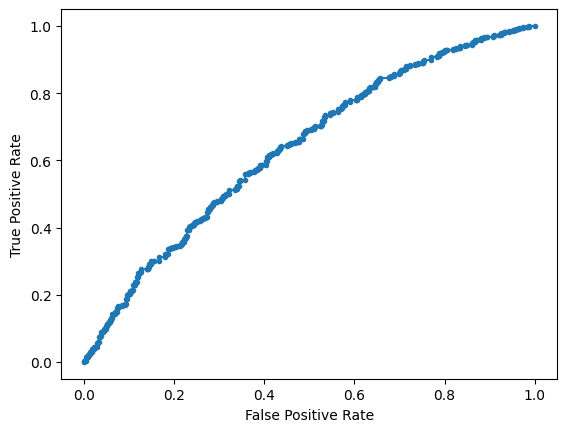

Accuracy: 60.64% Precision: 60.82% Recall: 73.12%
F1: 66.41% MCC: 0.2034
AUPRC: 63.93% AUROC: 63.67%
 accuracy [60.64073226544623]
 precision [60.82289803220036]
 recall [73.11827956989248]
 F1 [66.40625]
 MCC [0.20341613353749383]
 AUPRC [63.932042932693975]
 AUROC [63.66590425112392]

Training # 1 5
2023-05-01 13:16:31.052374
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.5.validation_genes.txt
Discriminator ZERO -1
Train 1:0 1785:1713 51.03%
Computed class weights: {0: 1.021015761821366, 1: 0.9798319327731092}
Valid 1:0 458:416 52.40%
FIT


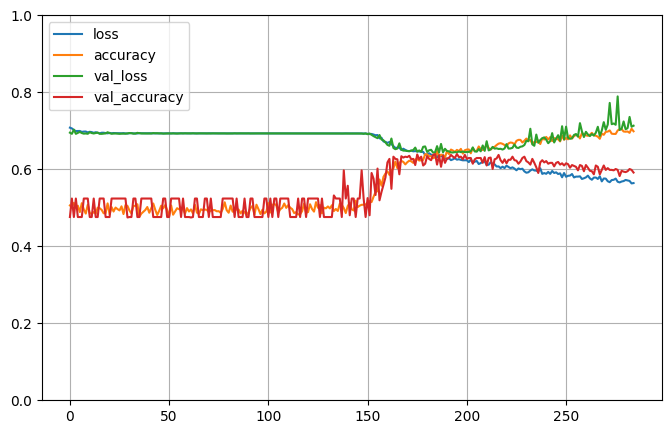

Saved model 1 to /content/drive/My Drive/data/Localization/Models/MLP_NoNo.1.5.model
Saved model 2 to /content/drive/My Drive/data/Localization/Models/GMM_NoNo.1.5.pickle

Testing # 1 5
2023-05-01 13:19:48.779875
PREDICT
Test 1:0 458:416 52.40%
Predict 1:0 485:389 55.49%
Test sizes (874, 1025) (874,)
Distrib of scores: 0.5161588 mean 0.13788182 std
Range of scores: 0.10083725 to 0.83185726
Score threshold 0.5
Confusion matrix
 [[245 171]
 [144 314]]
Normalized matrix
 [[0.28032037 0.19565217]
 [0.16475973 0.35926773]]
Extreme scores correct, pos:neg 111 76
Extreme scores incorrect pos:neg 48 24


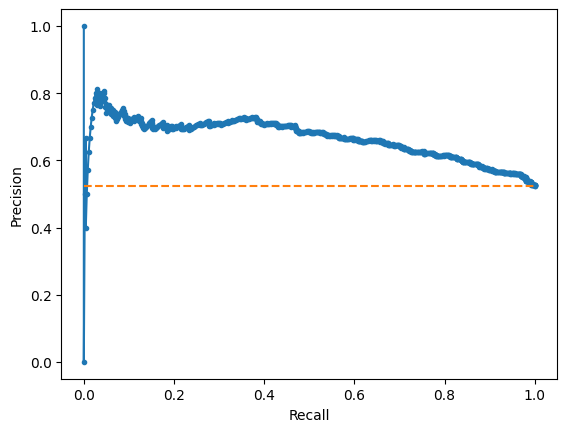

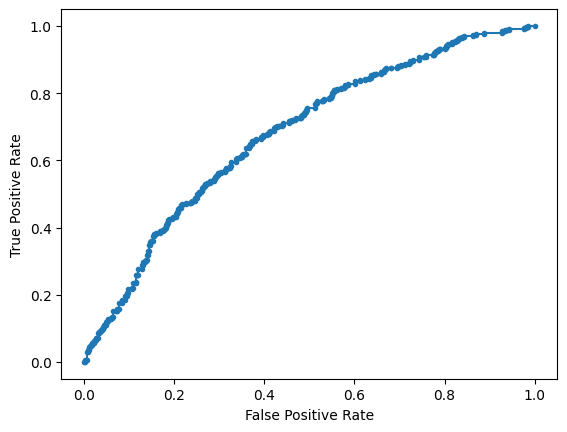

Accuracy: 63.96% Precision: 64.74% Recall: 68.56%
F1: 66.60% MCC: 0.2759
AUPRC: 66.53% AUROC: 67.87%
 accuracy [63.95881006864988]
 precision [64.74226804123711]
 recall [68.5589519650655]
 F1 [66.59597030752917]
 MCC [0.27588394985177406]
 AUPRC [66.52947206593245]
 AUROC [67.8687646960027]

Training # 2 1
2023-05-01 13:19:49.410447
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.1.validation_genes.txt
Discriminator ZERO -1
Train 1:0 1807:1690 51.67%
Computed class weights: {0: 1.0346153846153847, 1: 0.9676258992805755}
Valid 1:0 436:439 49.83%
FIT


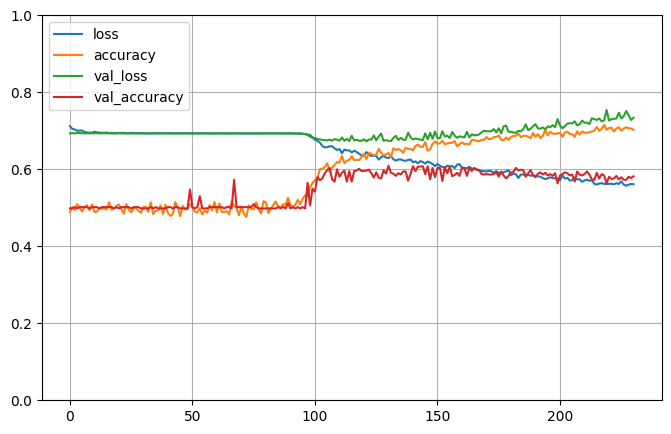

Saved model 1 to /content/drive/My Drive/data/Localization/Models/MLP_NoNo.2.1.model
Saved model 2 to /content/drive/My Drive/data/Localization/Models/GMM_NoNo.2.1.pickle

Testing # 2 1
2023-05-01 13:22:25.637074
PREDICT
Test 1:0 436:439 49.83%
Predict 1:0 484:391 55.31%
Test sizes (875, 1025) (875,)
Distrib of scores: 0.5177866 mean 0.14749819 std
Range of scores: 0.0626788 to 0.8640107
Score threshold 0.5
Confusion matrix
 [[244 195]
 [147 289]]
Normalized matrix
 [[0.27885714 0.22285714]
 [0.168      0.33028571]]
Extreme scores correct, pos:neg 104 81
Extreme scores incorrect pos:neg 62 38


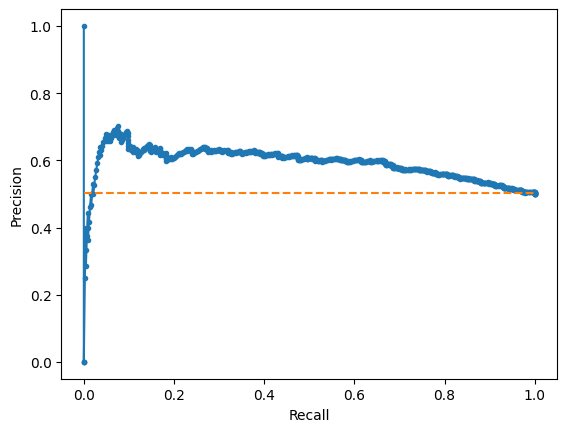

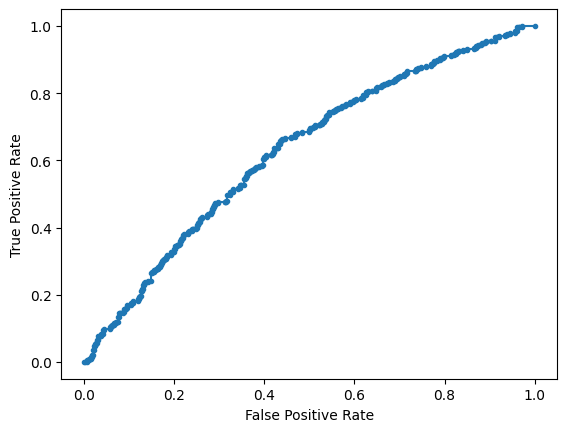

Accuracy: 60.91% Precision: 59.71% Recall: 66.28%
F1: 62.83% MCC: 0.2199
AUPRC: 59.10% AUROC: 62.77%
 accuracy [60.91428571428571]
 precision [59.71074380165289]
 recall [66.28440366972477]
 F1 [62.826086956521735]
 MCC [0.21989698526930518]
 AUPRC [59.09672876839376]
 AUROC [62.77455016614073]

Training # 2 2
2023-05-01 13:22:26.248010
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.2.validation_genes.txt
Discriminator ZERO -1
Train 1:0 1794:1703 51.30%
Computed class weights: {0: 1.0267175572519085, 1: 0.9746376811594203}
Valid 1:0 449:426 51.31%
FIT


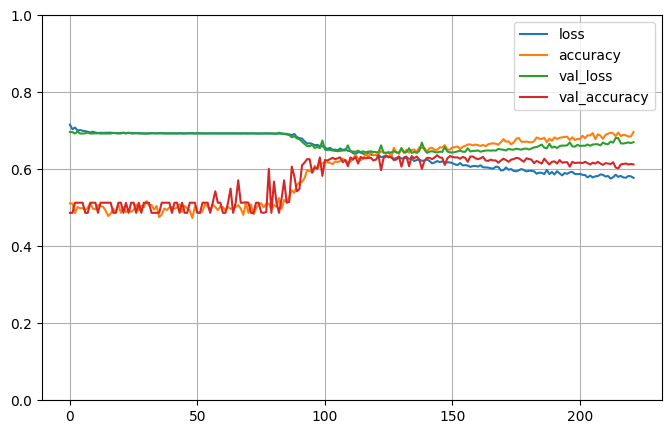

Saved model 1 to /content/drive/My Drive/data/Localization/Models/MLP_NoNo.2.2.model
Saved model 2 to /content/drive/My Drive/data/Localization/Models/GMM_NoNo.2.2.pickle

Testing # 2 2
2023-05-01 13:24:50.674675
PREDICT
Test 1:0 449:426 51.31%
Predict 1:0 507:368 57.94%
Test sizes (875, 1025) (875,)
Distrib of scores: 0.5200487 mean 0.14550555 std
Range of scores: 0.067589775 to 0.82607186
Score threshold 0.5
Confusion matrix
 [[238 188]
 [130 319]]
Normalized matrix
 [[0.272      0.21485714]
 [0.14857143 0.36457143]]
Extreme scores correct, pos:neg 121 94
Extreme scores incorrect pos:neg 61 21


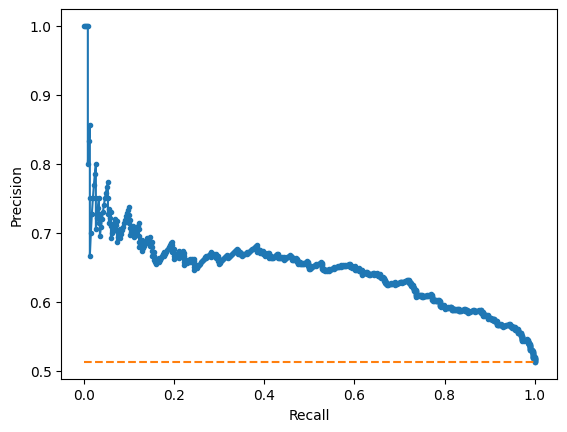

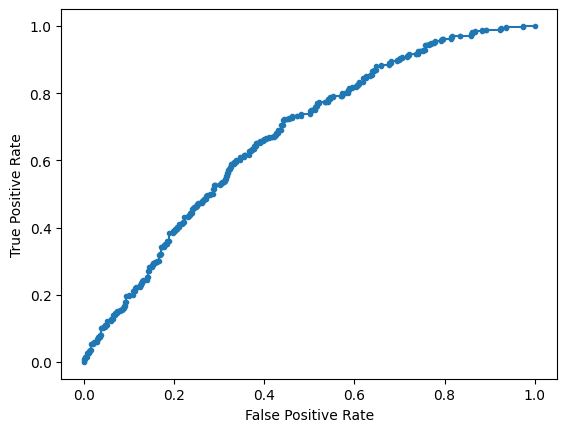

Accuracy: 63.66% Precision: 62.92% Recall: 71.05%
F1: 66.74% MCC: 0.2725
AUPRC: 64.76% AUROC: 67.16%
 accuracy [63.65714285714286]
 precision [62.91913214990138]
 recall [71.0467706013363]
 F1 [66.73640167364016]
 MCC [0.27252073476534583]
 AUPRC [64.76116924666128]
 AUROC [67.15706264311929]

Training # 2 3
2023-05-01 13:24:51.660360
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.3.validation_genes.txt
Discriminator ZERO -1
Train 1:0 1771:1727 50.63%
Computed class weights: {0: 1.0127388535031847, 1: 0.9875776397515528}
Valid 1:0 472:402 54.00%
FIT


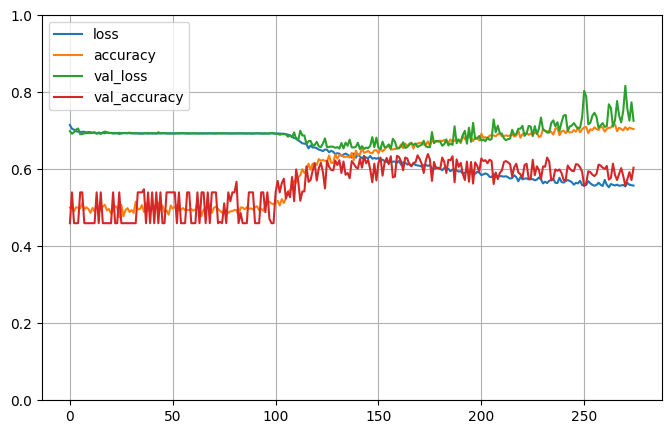

Saved model 1 to /content/drive/My Drive/data/Localization/Models/MLP_NoNo.2.3.model
Saved model 2 to /content/drive/My Drive/data/Localization/Models/GMM_NoNo.2.3.pickle

Testing # 2 3
2023-05-01 13:28:17.610804
PREDICT
Test 1:0 472:402 54.00%
Predict 1:0 573:301 65.56%
Test sizes (874, 1025) (874,)
Distrib of scores: 0.55372345 mean 0.17922938 std
Range of scores: 0.046958525 to 0.8701498
Score threshold 0.5
Confusion matrix
 [[194 208]
 [107 365]]
Normalized matrix
 [[0.22196796 0.23798627]
 [0.12242563 0.41762014]]
Extreme scores correct, pos:neg 196 90
Extreme scores incorrect pos:neg 109 37


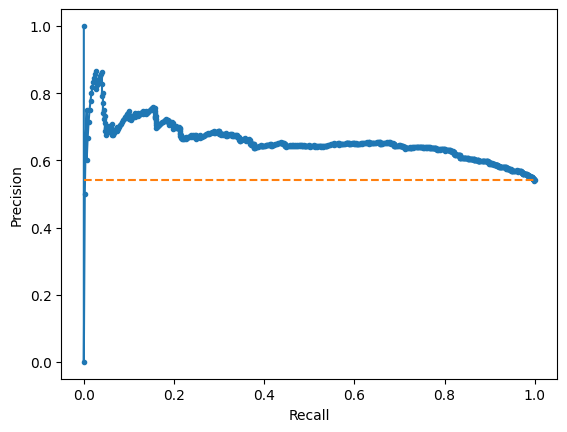

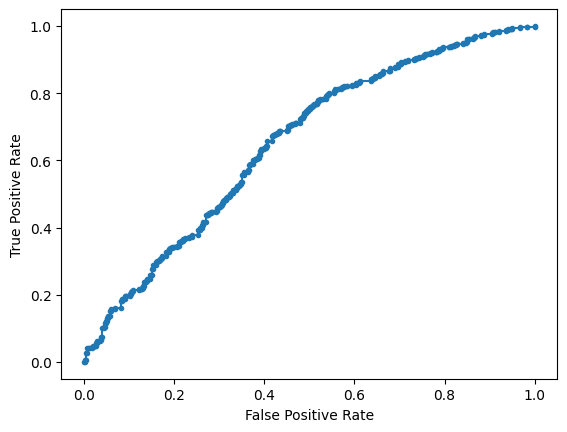

Accuracy: 63.96% Precision: 63.70% Recall: 77.33%
F1: 69.86% MCC: 0.2684
AUPRC: 65.55% AUROC: 65.22%
 accuracy [63.95881006864988]
 precision [63.6998254799302]
 recall [77.33050847457628]
 F1 [69.85645933014354]
 MCC [0.26839871320372277]
 AUPRC [65.55155906899589]
 AUROC [65.21576439834725]

Training # 2 4
2023-05-01 13:28:18.317597
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.4.validation_genes.txt
Discriminator ZERO -1
Train 1:0 1816:1682 51.92%
Computed class weights: {0: 1.039833531510107, 1: 0.9631057268722467}
Valid 1:0 427:447 48.86%
FIT


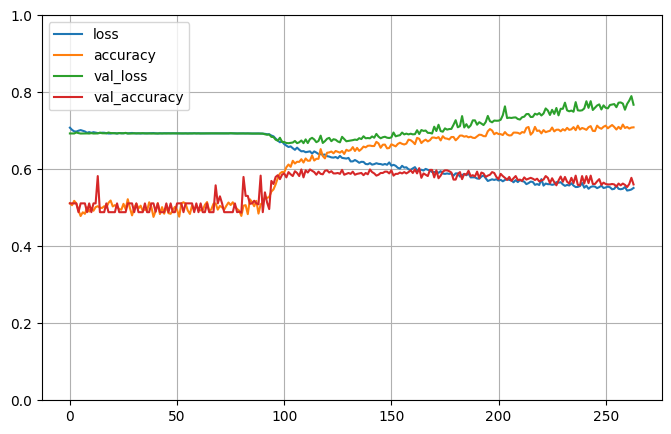

Saved model 1 to /content/drive/My Drive/data/Localization/Models/MLP_NoNo.2.4.model
Saved model 2 to /content/drive/My Drive/data/Localization/Models/GMM_NoNo.2.4.pickle

Testing # 2 4
2023-05-01 13:31:19.315193
PREDICT
Test 1:0 427:447 48.86%
Predict 1:0 424:450 48.51%
Test sizes (874, 1025) (874,)
Distrib of scores: 0.4868998 mean 0.19618347 std
Range of scores: 0.048106566 to 0.8953251
Score threshold 0.5
Confusion matrix
 [[275 172]
 [175 252]]
Normalized matrix
 [[0.31464531 0.19679634]
 [0.20022883 0.28832952]]
Extreme scores correct, pos:neg 128 145
Extreme scores incorrect pos:neg 78 72


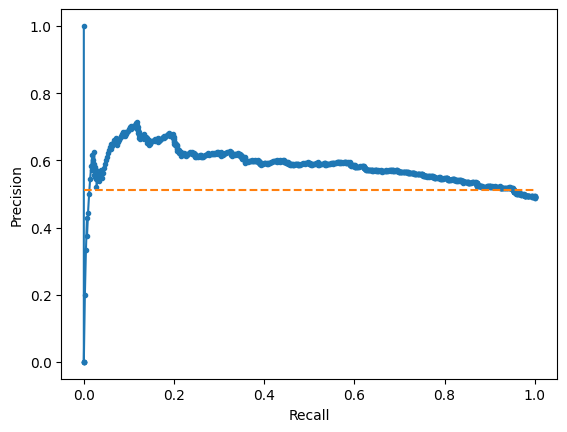

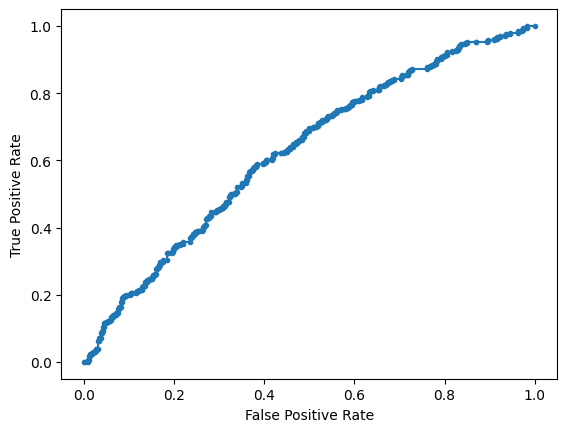

Accuracy: 60.30% Precision: 59.43% Recall: 59.02%
F1: 59.22% MCC: 0.2054
AUPRC: 58.40% AUROC: 62.55%
 accuracy [60.297482837528605]
 precision [59.43396226415094]
 recall [59.01639344262295]
 F1 [59.22444183313749]
 MCC [0.2054135947147423]
 AUPRC [58.40415810177449]
 AUROC [62.5460394301851]

Training # 2 5
2023-05-01 13:31:19.961898
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.5.validation_genes.txt
Discriminator ZERO -1
Train 1:0 1784:1714 51.00%
Computed class weights: {0: 1.0204200700116686, 1: 0.9803811659192825}
Valid 1:0 459:415 52.52%
FIT


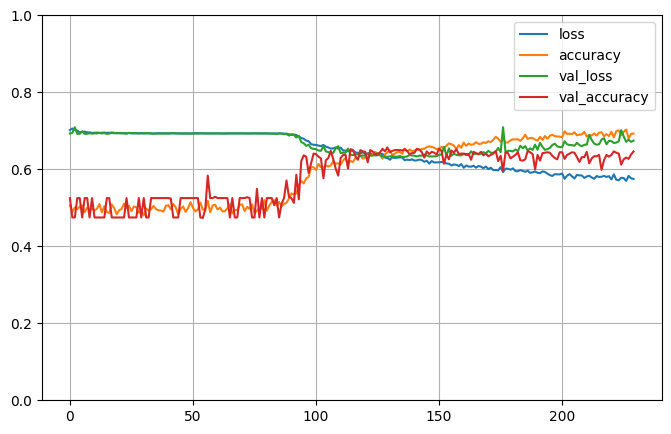

Saved model 1 to /content/drive/My Drive/data/Localization/Models/MLP_NoNo.2.5.model
Saved model 2 to /content/drive/My Drive/data/Localization/Models/GMM_NoNo.2.5.pickle

Testing # 2 5
2023-05-01 13:34:44.930330
PREDICT
Test 1:0 459:415 52.52%
Predict 1:0 493:381 56.41%
Test sizes (874, 1025) (874,)
Distrib of scores: 0.51530087 mean 0.15057923 std
Range of scores: 0.04976766 to 0.82469183
Score threshold 0.5
Confusion matrix
 [[248 167]
 [133 326]]
Normalized matrix
 [[0.28375286 0.19107551]
 [0.15217391 0.37299771]]
Extreme scores correct, pos:neg 131 91
Extreme scores incorrect pos:neg 39 37


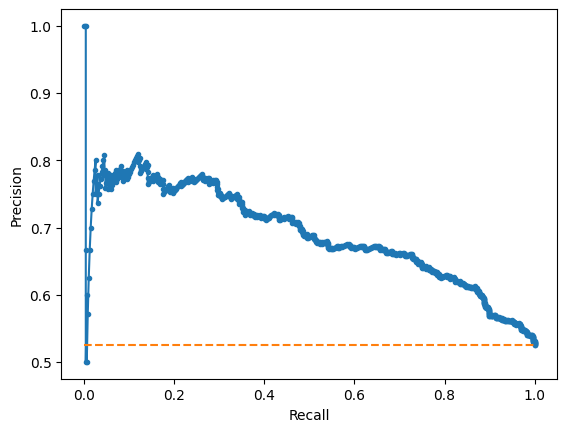

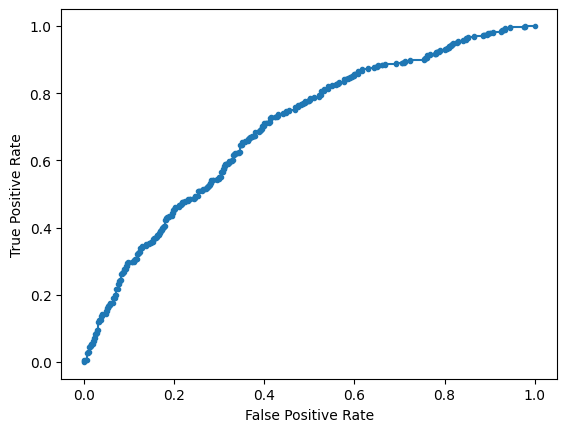

Accuracy: 65.68% Precision: 66.13% Recall: 71.02%
F1: 68.49% MCC: 0.3100
AUPRC: 69.04% AUROC: 69.52%
 accuracy [65.67505720823799]
 precision [66.12576064908721]
 recall [71.0239651416122]
 F1 [68.4873949579832]
 MCC [0.30999551042851137]
 AUPRC [69.04274360554643]
 AUROC [69.51780980129668]
2023-05-01 13:34:45.873460


In [7]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader(K,ALPHABET)
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)  # for MLP (load_sequence() for CNN)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader(K,ALPHABET)
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

for repeat in range(REPEATS):
    for fold in range(FOLDS):
        show_r = repeat+1  # display one-based counting
        show_f = fold+1    # display one-based counting

        print()
        print("Training #",show_r,show_f)
        print(datetime.now())
        builder = ModelBuilder(ALPHABET)
        cvdo = CrossValidator(EPOCHS,RCI_THRESHOLD_VALUE)
        cvdo.set_model_builder(builder)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        
        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.set_middle(FILTER_TEST,FILTER_TAILS_TEST,FILTER_MIDDLE_TEST,\
                                 FILTER_TRAIN,FILTER_TAILS_TRAIN,FILTER_MIDDLE_TRAIN,\
                                 MIDDLE_LOW,MIDDLE_HIGH)
            separator.load(DATA_DIR,show_r,show_f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                test_allids,test_allseq,test_gene_to_rci)
            if SAVE_MODEL_FILENAME is not None:
                filename1 = f"{SAVE_MODEL_FILENAME}.{show_r}.{show_f}.model"
                filename2 = f"{SAVE_DESCRIM_FILENAME}.{show_r}.{show_f}.pickle"
                model,discrim = cvdo.get_models()
                save_model(model,discrim,filename1,filename2)
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            BREAK = True
            if LOAD_MODEL_FILENAME is not None:
                filename1 = LOAD_MODEL_FILENAME
                filename2 = LOAD_DESCRIM_FILENAME
                model, descrim = load_model(filename1, filename2)
                cvdo.set_models(model, descrim)
            else:
                cvdo.train_new_model(
                    train_allids,train_allseq,train_gene_to_rci,
                    None,None,None)

        print()
        print("Testing #",show_r,show_f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [8]:
def STD (values):
    # ddof=1 reduces bias when extrapolating from sample to population
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.4f std %.4f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 62.53% std 2.06
 precision mean 62.21% std 2.22
 recall mean 68.33% std 5.20
 F1 mean 65.07% std 3.24
 MCC mean 0.2481 std 0.0410
 AUPRC mean 63.48% std 3.31
 AUROC mean 65.48% std 2.43
 accuracy [[64.34285714285714], [59.65714285714285], [62.24256292906178], [60.64073226544623], [63.95881006864988], [60.91428571428571], [63.65714285714286], [63.95881006864988], [60.297482837528605], [65.67505720823799]]
 precision [[62.84501061571125], [60.631578947368425], [61.17136659436009], [60.82289803220036], [64.74226804123711], [59.71074380165289], [62.91913214990138], [63.6998254799302], [59.43396226415094], [66.12576064908721]]
 recall [[68.36027713625866], [63.436123348017624], [65.1270207852194], [73.11827956989248], [68.5589519650655], [66.28440366972477], [71.0467706013363], [77.33050847457628], [59.01639344262295], [71.0239651416122]]
 F1 [[65.48672566371681], [62.00215285252961], [63.08724832214765], [66.40625], [66.59597030752917], [62.826086956521735], [66.736401673640